In [8]:
# Import necessary dependencies & libraries
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Create engine to connect with our database
engine = create_engine("sqlite:///hawaii.sqlite")

# Reflect an existing database into a new model
base = automap_base()

# Reflect the tables in our database
base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the most recent data in the database
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f'The most recent date is: {most_recent_date}')

# Find the date exactly 1 year previous to our most recent date
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f'The date a year from our most recent date is: {year_ago}')

The most recent date is: ('2017-08-23',)
The date a year from our most recent date is: 2016-08-23


In [14]:
#  Perform a query to retrieve the date and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp)\
              .filter(measurement.date >= year_ago)\
              .order_by(measurement.date).all()

# Create a Pandas DataFrame, set index to the date column, & sorted by date
precip_df = pd.DataFrame(precip_data)
precip_df = precip_df.set_index('date')
precip_df = precip_df.sort_values('date')
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


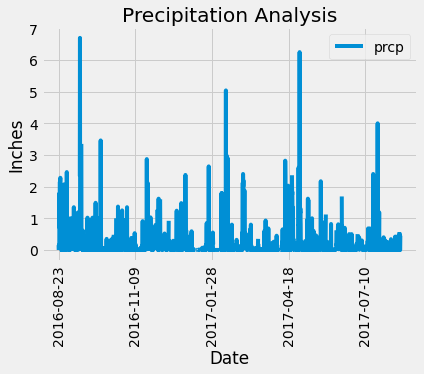

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=90);
plt.title('Precipitation Analysis');
plt.xlabel('Date');
plt.ylabel('Inches');
plt.show();

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# How many stations are available in this dataset?
station_count = session.query(station).count()
print(f'There are a total of {station_count} stations')

There are a total of 9 stations


In [18]:
# List the stations & counts in descending order to find most active stations
most_active = session.query(measurement.station, func.count(measurement.station))\
            .group_by(measurement.station)\
            .order_by(func.count(measurement.station).desc())\
            .all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Calculate lowest, highest, & average temp of most active station
most_active_station = most_active[0][0]
mas_data = session.query(func.min(measurement.tobs),\
                         func.max(measurement.tobs),\
                         func.avg(measurement.tobs))\
                         .filter(measurement.station == most_active_station)\
                         .all()
min_temp = mas_data[0][0]
max_temp = mas_data[0][1]
avg_temp = round(mas_data[0][-1],2)

print(f'Station USC00519281 lowestest temp: {min_temp} degrees')
print(f'Station USC00519281 highest temp: {max_temp} degrees')
print(f'Station USC00519281 average temp: {avg_temp} degrees')

Station USC00519281 lowestest temp: 54.0 degrees
Station USC00519281 highest temp: 85.0 degrees
Station USC00519281 average temp: 71.66 degrees


In [20]:
# Query last 12 months of temperature observation data for above station
mas_last_twelve = session.query(measurement.station, measurement.tobs)\
                    .filter(measurement.station == most_active_station)\
                    .filter(measurement.date >= year_ago)\
                    .all()
mas_df = pd.DataFrame(mas_last_twelve)
mas_df = mas_df.set_index('station')
mas_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


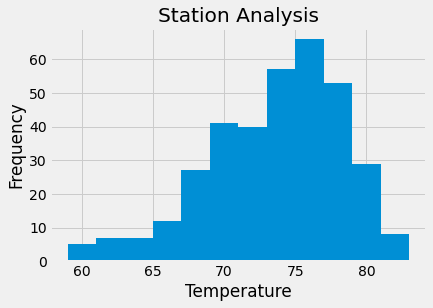

In [21]:
# Plot the results as a histogram

mas_df.hist(column='tobs',bins=12);
plt.title('Station Analysis');
plt.xlabel('Temperature');
plt.ylabel('Frequency');

## Bonus Challenge Assignment: Temperature Analysis II

In [41]:
# Function to find min, avg, and max temp for the imputted range of dates
def calc_temps(start_date, end_date):    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
print(calc_temps('2011-02-05', '2012-02-05'))

[(58.0, 72.81208791208792, 86.0)]


In [42]:
# Using the calc_temps func, calc the tmin, tavg, and tmax of the previous year from above
trip = calc_temps('2011-02-28', '2012-02-28')
trip

[(56.0, 72.76152158010241, 86.0)]

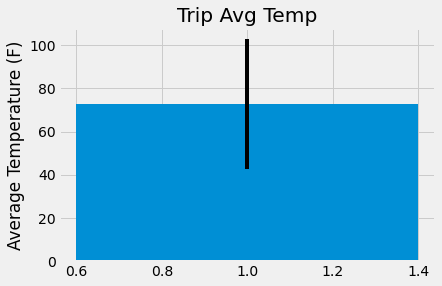

In [46]:
# Plot the results from above as a bar chart. 
tmin = trip[0][0]
tavg = trip[0][1]
tmax = trip[0][2]
y_err = tmax - tmin
x = 1
y = tavg

plt.bar(x, y, yerr = y_err);
plt.title("Trip Avg Temp");
plt.ylabel("Average Temperature (F)");

In [61]:
# Calc total rainfall per weather station for the previous trip above
# Sort prcp amount in desc order, listing id, name, lat, long, & elevation 
bonus_start = '2011-02-28'
bonus_end = '2012-02-28'

bonus_trip = [station.station, station.name, func.sum(measurement.prcp), 
              station.latitude, station.longitude, station.elevation]

total_rainfall = session.query(*bonus_trip).filter(measurement.station == station.station)\
                .filter(measurement.date >= bonus_start).filter(measurement.date <= bonus_end)\
                .group_by(station.name).order_by(func.sum(measurement.prcp).desc()).all()

total_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  130.84,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  61.83999999999997,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  46.38999999999995,
  21.4234,
  -157.8015,
  14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  28.43000000000001,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  23.17000000000001,
  21.33556,
  -157.71139,
  19.5),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  18.09999999999999,
  21.4992,
  -158.0111,
  306.6),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  17.879999999999985,
  21.2716,
  -157.8168,
  3.0),
 ('USC00517948',
  'PEARL CITY, HI US',
  11.569999999999999,
  21.3934,
  -157.9751,
  11.9),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  10.639999999999992,
  21.3152,
  -157.9992,
  0.9)]